In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt

## Exploring MNIST dataset

### Downloading/Loading torchvision.dataset.MNIST as Tensors.

In [98]:
dataset = MNIST(root='data/', transform=transforms.ToTensor())

img_tensor, label = dataset[0]
print(img_tensor.shape)

torch.Size([1, 28, 28])


In [99]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

Plotting first 10 images in the dataset along with their target labels.

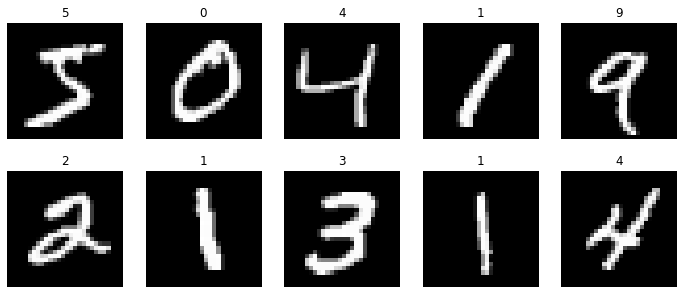

In [97]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

for i in range(10):
    axes[i//5, i%5].imshow(dataset[i][0][0,:,:], cmap='gray')
    axes[i//5, i%5].set_title(dataset[i][1])
    axes[i//5, i%5].axis("off")

### Splitting dataset to training and validation

In [18]:
val_split = (1/6)

val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size

In [19]:
train_set, val_set = random_split(dataset, [train_size, val_size])

print(len(train_set), len(val_set))

50000 10000


### Creating dataloader

In [20]:
batch_size = 10000

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)

### Defining model

In [21]:
input_size = 28*28
num_classes = 10

In [22]:
class Model(torch.nn.Module):
    def __init__(self, input_size, hidden_size, out_size, loss_func, learning_rate):
        super().__init__()
        # Loss function
        self.loss_func = loss_func
        # Hidden Layer
        self.linear1 = nn.Linear(input_size, hidden_size)
        # Output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        # Optimizer
        self.opt = torch.optim.SGD(self.parameters(), lr=learning_rate)
            
    ## Returns the value after forward pass
    def forward(self, x):
        
        # Reshaping from 28x28 to 784, and first value (-1)
        x = x.reshape(-1, 784)
        # First linear layer
        x1 = self.linear1(x)
        # Activation layer
        a1 = F.relu(x1)
        # Output linear layer
        x2 = self.linear2(a1)
        return x2
    
    ## Returns loss for a training batch
    def training_step(self, batch):
        images, labels = batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        loss = self.loss_func(out, labels) 
        return loss
    
    ## Returns the loss and accuracy for a validation batch
    def validation_step(self, val_batch):
        images, labels = val_batch 
        
        # Generate predictions
        out = self(images)            
        
        # Calculate loss
        val_loss = self.loss_func(out, labels) 
        val_acc = accuracy(out, labels)
        
        return {"val_loss":val_loss, "val_acc":val_acc}
    
    ## Returns mean loss and mean accuracy from the losses and accuracies of all the batches
    def validation_epoch_end(self, outputs):
        
        # Losses for each batch
        batch_losses = [x['val_loss'] for x in outputs]
        
        # Mean loss for all batch
        batch_mean_loss = torch.tensor(batch_losses).mean()
        
        # Accuracies for each batches
        batch_accs = [x['val_acc'] for x in outputs]
        
        # Mean accuracy for all batches
        batch_mean_acc = torch.tensor(batch_accs).mean()
        
        return {"val_loss":batch_mean_loss, "val_acc":batch_mean_acc}
    
    ## Prints validation loss and accuracy for epoch (mean of all batches)
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

Checking sample outputs from instantiated model using one batch of dataset.

### Evaluation metric

Defining accuracy as total correct no. of predictions predictions divided by total no. of predictions.

In [23]:
# Accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Using a GPU

First we check whether CUDA is available or not.

In [8]:
torch.cuda.is_available()

True

Function to get GPU device if available, else CPU.

In [9]:
def get_default_device():
  if(torch.cuda.is_available()):
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [10]:
device = get_default_device()
device

device(type='cuda')

Function fo move data and model to the available device.

In [13]:
def to_device(data, device):
  # If data is list or tuple, perform to_device for each element
  if(isinstance(data, (list, tuple))):
    return([to_device(x, device) for x in data])
    
  return data.to(device, non_blocking = True)

In [12]:
# Example of moving data to device
to_device(torch.Tensor([1,2,3]), device)

tensor([1., 2., 3.], device='cuda:0')

In [24]:
for images, labels in train_loader:
  images = to_device(images, device)
  print(images.device)
  break

cuda:0


We define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. 

We don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [25]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    return(len(self.dl))

We can now wrap our data loaders using `DeviceDataLoader`.

In [28]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Let us check the device of these dataloaders.

In [31]:
for im, lb in train_loader:
  print(im.device)
  print(lb)
  break

for im, lb in val_loader:
  print(im.device)
  print(lb)
  break

cuda:0
tensor([7, 1, 4,  ..., 3, 5, 8], device='cuda:0')
cuda:0
tensor([1, 5, 6,  ..., 2, 5, 3], device='cuda:0')


### Training

In [32]:
# Utility function to train the model

def fit(epochs, model, train_loader, val_loader):
    print("Training")
    
    # For recording epoch wise results
    history = []
    
    for i in range(epochs):
        for batch in train_loader:
            
            # Make prediction & Calculate loss
            loss = model.training_step(batch)
            
            # Compute gradients
            loss.backward()
            
            # Update parameters using gradients
            model.opt.step()
            
            # Reset gradients to zero
            model.opt.zero_grad()
            
        ## Validation phase 
        result = evaluate(model, val_loader)
        model.epoch_end(i, result)
        history.append(result)
            
    return history

In [33]:
def evaluate(model, val_loader):
    
    # List containing evaluations for every batch
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

### Creating and training model

In [34]:
# Hyperparameters
hidden_size = 32
loss_func = F.cross_entropy
learning_rate = 0.1

# Create model
model = Model(input_size = input_size, hidden_size = hidden_size, out_size = num_classes, 
              loss_func = loss_func, 
              learning_rate = learning_rate)

# Moving model to device
to_device(model, device)

Model(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [35]:
history = fit(30, model, train_loader, val_loader)

Training
Epoch [0], val_loss: 2.2256, val_acc: 0.3353
Epoch [1], val_loss: 2.1293, val_acc: 0.4605
Epoch [2], val_loss: 2.0169, val_acc: 0.5459
Epoch [3], val_loss: 1.8884, val_acc: 0.6247
Epoch [4], val_loss: 1.7468, val_acc: 0.6777
Epoch [5], val_loss: 1.5971, val_acc: 0.7094
Epoch [6], val_loss: 1.4476, val_acc: 0.7277
Epoch [7], val_loss: 1.3087, val_acc: 0.7403
Epoch [8], val_loss: 1.1865, val_acc: 0.7508
Epoch [9], val_loss: 1.0827, val_acc: 0.7648
Epoch [10], val_loss: 0.9955, val_acc: 0.7788
Epoch [11], val_loss: 0.9230, val_acc: 0.7898
Epoch [12], val_loss: 0.8622, val_acc: 0.8002
Epoch [13], val_loss: 0.8108, val_acc: 0.8109
Epoch [14], val_loss: 0.7667, val_acc: 0.8187
Epoch [15], val_loss: 0.7286, val_acc: 0.8248
Epoch [16], val_loss: 0.6954, val_acc: 0.8336
Epoch [17], val_loss: 0.6664, val_acc: 0.8414
Epoch [18], val_loss: 0.6406, val_acc: 0.8481
Epoch [19], val_loss: 0.6177, val_acc: 0.8524
Epoch [20], val_loss: 0.5972, val_acc: 0.8570
Epoch [21], val_loss: 0.5788, val_a

Now we plot the evaluation metrics for all epochs.

In [36]:
losses = [l['val_loss'] for l in history]
acc = [a['val_acc'] for a in history]

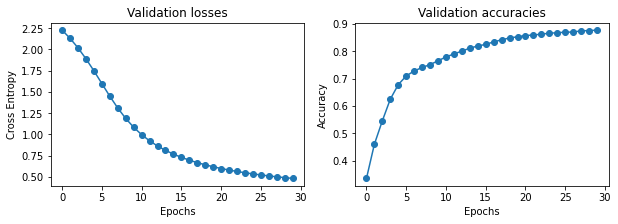

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))

axes[0].plot(losses, '-o')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Cross Entropy")
axes[0].set_title("Validation losses")

axes[1].plot(acc, '-o')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation accuracies")
plt.show()

### Checking model performance on test dataset

In [50]:
# Testing dataset

test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
len(test_dataset)

10000

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [57]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)

In [58]:
result = evaluate(model, test_loader)
print("Test Loss = {:.4f}, Test accuracy = {:.4F}".format(result['val_loss'], result['val_acc']))

Test Loss = 0.4687, Test accuracy = 0.8797


In [76]:
for img, lab in test_loader:
  test_labels = lab
  test_output_probs = model(img)
  break

_, test_output = torch.max(test_output_probs, dim = 1)

Now we visualize the test images with their predicted labels.

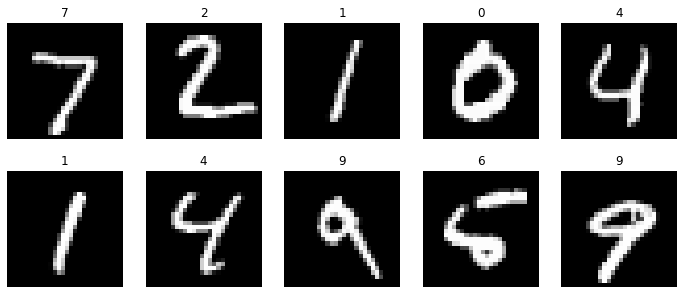

In [92]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))

for i in range(10):
    axes[i//5, i%5].imshow(test_dataset[i][0][0,:,:], cmap='gray')
    axes[i//5, i%5].set_title(test_output[i].item())
    axes[i//5, i%5].axis("off")

In [95]:
print(test_output[:10])
print(test_labels[:10])

tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], device='cuda:0')
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0')
